<a href="https://colab.research.google.com/github/tiwarylab/carboost/blob/main/CARBOOST_toolkit_with_colabfold_and_rMSA_AF2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CAR BOOST demonstration notebook

#### In the following notebook we will display how the `carboost` protocol is applied to predict a CAR construct with maximal responsiveness.
#### For this demonstration purpose we will be predicting an optimal CAR hinge sequence length (derived from CD8 $\alpha$) targetting **CD22 receptor**.


![alternative text](https://github.com/tiwarylab/carboost/blob/main/img/fig3_f_targetsl.png?raw=1)

#### Following the protocol mentioned above we will be modelling the target recepor first to extract its end-to-end distance distribution a synapse. Generally, target modelling can fall into 2 categories

##### (1) **Category 1**: Target receptor contains a disordered hinge-like region connecting an ordered extracellular domain to the anchoring transmembrane domain
##### (2) **Category 2**: Target receptor does not contain any disordered hinge-like region.

##### Further based on the type of modeling the `carboost` protocol has the two following modes:
##### (a) `target_type` = "dynamic": This mode models the target as an ensemble irrespective of its category
##### (a) `target_type` = "rigid": This mode models the target as a rigid system. In cases of targets like CD20 this mode of `carboost` can be used.

<img src="https://github.com/tiwarylab/carboost/blob/main/img/target_classification.png?raw=1" alt="alternative text" width="500">


***

In [3]:
#@title Install `carboost`
%cd /content/

!pip install "git+https://github.com/tiwarylab/carboost.git"

import warnings
import os
try:
    import carboost
    print("------------------------------------------------------------------------------")
    print(f"\n\n\n`carboost` (version: {carboost.__version__}) is installed and imported")
    print(f"The current directory is: {os.getcwd()}")
except ImportError:
    warnings.warn('`carboost` failed to import', ImportWarning)

/content
  Cloning https://github.com/tiwarylab/carboost.git to /tmp/pip-req-build-od85rqgl
  Running command git clone --filter=blob:none --quiet https://github.com/tiwarylab/carboost.git /tmp/pip-req-build-od85rqgl
  Resolved https://github.com/tiwarylab/carboost.git to commit 147b8e8134d40024c951aa02463da9fb8f859488
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
------------------------------------------------------------------------------



`carboost` (version: 0.1.0) is installed and imported
The current directory is: /content


In [4]:
#@title Install `colabfold`

import os
if not os.path.isfile("COLABFOLD_READY"):
  print("installing colabfold...")
  os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")
  if os.environ.get('TPU_NAME', False) != False:
    os.system("pip uninstall -y jax jaxlib")
    os.system("pip install --no-warn-conflicts --upgrade dm-haiku==0.0.10 'jax[cuda12_pip]'==0.3.25 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
  # hack to fix TF crash
  os.system("rm -f /usr/local/lib/python3.*/dist-packages/tensorflow/core/kernels/libtfkernel_sobol_op.so")
  os.system("touch COLABFOLD_READY")

try:
  K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
except:
  K80_chk = "0"
  pass
if "1" in K80_chk:
  print("WARNING: found GPU Tesla K80: limited to total length < 1000")
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]



## 1. Target modelling

Target: **CD33**

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import mdtraj as md

#@markdown Please provide the seuquence of the extracellular domain of the target receptor

Extra_cellular_region_sequence = 'DPNFWLQVQESVTVQEGLCVLVPCTFFHPIPYYDKNSPVHGYWFREGAIISRDSPVATNKLDQEVQEETQGRFRLLGDPSRNNCSLSIVDARRRDNGSYFFRMERGSTKYSYKSPQLSVHVTDLTHRPKILIPGTLEPGHSKNLTCSVSWACEQGTPPIFSWLSAAPTSLGPRTTHSSVLIITPRPQDHGTNLTCQVKFAGAGVTTERTIQLNVTYVPQNPTTGIFPGDGSGKQETRAGVVH' #@param {type:"string"}

#@markdown Please provide the seuquence of the transmembrane domain of the target receptor

TM_region_sequence = 'GAIGGAGVTALLALCLCLIFFIVKTHRRKAARTAVG' #@param {type:"string"}

#@markdown Please provide the epitope region for the target receptor. Discontinous regions are separated with a ','.

epitope_region = '1-7,26-33,81-82,107-110' #@param {type:"string"}

zero_based_index = False #@param {type:"boolean"}

target_sequence = Extra_cellular_region_sequence+TM_region_sequence

if zero_based_index:
    epitope_region = [[int(resid) for resid in region.split('-')] for region in epitope_region.split(',')]
else:
    epitope_region = [[int(resid)-1 for resid in region.split('-')] for region in epitope_region.split(',')]


## 1.a Target tertiary and secondary structure analysis

A regular Alphafold2 run with colabfold is performed to assess the structure of the target receptor (CD33).

In [6]:
import os
path_base = os.getcwd()

In [7]:
from carboost.folding import ColabFoldRunConfig, run_colabfold_pipeline

#@markdown Enter the output dir
output_dir_full_sequence = 'CD33_full_structure' #@param {type:"string"}

config = ColabFoldRunConfig(
    query_sequence = target_sequence,
    num_seeds = 1,
    max_msa='512:1024'
)

summary = run_colabfold_pipeline(
    config=config,
    output_dir=f"{path_base}/{output_dir_full_sequence}",
    zip_output=True,
    show_msa_plot=False,
    show_prediction_plot=False,
)

2026-02-19 21:43:46,670 Running on GPU
2026-02-19 21:43:46,962 Found 4 citations for tools or databases
2026-02-19 21:43:46,962 Query 1/1: test42_0bdba (length 278)


PENDING:   0%|          | 0/150 [elapsed: 00:00 remaining: ?]

2026-02-19 21:43:47,264 Sleeping for 10s. Reason: PENDING


RUNNING:   7%|▋         | 10/150 [elapsed: 00:10 remaining: 02:28]

2026-02-19 21:43:57,576 Sleeping for 8s. Reason: RUNNING


RUNNING:  12%|█▏        | 18/150 [elapsed: 00:18 remaining: 02:18]

2026-02-19 21:44:05,893 Sleeping for 10s. Reason: RUNNING


RUNNING:  19%|█▊        | 28/150 [elapsed: 00:29 remaining: 02:06]

2026-02-19 21:44:16,197 Sleeping for 10s. Reason: RUNNING


RUNNING:  25%|██▌       | 38/150 [elapsed: 00:39 remaining: 01:55]

2026-02-19 21:44:26,487 Sleeping for 7s. Reason: RUNNING


RUNNING:  30%|███       | 45/150 [elapsed: 00:46 remaining: 01:49]

2026-02-19 21:44:33,871 Sleeping for 7s. Reason: RUNNING


RUNNING:  35%|███▍      | 52/150 [elapsed: 00:54 remaining: 01:42]

2026-02-19 21:44:41,179 Sleeping for 10s. Reason: RUNNING


RUNNING:  41%|████▏     | 62/150 [elapsed: 01:04 remaining: 01:31]

2026-02-19 21:44:51,487 Sleeping for 7s. Reason: RUNNING


RUNNING:  46%|████▌     | 69/150 [elapsed: 01:11 remaining: 01:24]

2026-02-19 21:44:58,813 Sleeping for 10s. Reason: RUNNING


COMPLETE: 100%|██████████| 150/150 [elapsed: 01:22 remaining: 00:00]


2026-02-19 21:45:11,160 Setting max_seq=512, max_extra_seq=1024
2026-02-19 21:46:30,967 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=81.4 pTM=0.675
2026-02-19 21:47:16,544 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=84.5 pTM=0.699 tol=2.08
2026-02-19 21:47:16,545 alphafold2_ptm_model_1_seed_000 took 110.3s (1 recycles)
2026-02-19 21:47:18,943 alphafold2_ptm_model_2_seed_000 recycle=0 pLDDT=80.9 pTM=0.671
2026-02-19 21:47:21,250 alphafold2_ptm_model_2_seed_000 recycle=1 pLDDT=81.2 pTM=0.676 tol=2.89
2026-02-19 21:47:21,251 alphafold2_ptm_model_2_seed_000 took 4.6s (1 recycles)
2026-02-19 21:47:23,653 alphafold2_ptm_model_3_seed_000 recycle=0 pLDDT=83.6 pTM=0.691
2026-02-19 21:47:25,980 alphafold2_ptm_model_3_seed_000 recycle=1 pLDDT=83.6 pTM=0.699 tol=2
2026-02-19 21:47:25,981 alphafold2_ptm_model_3_seed_000 took 4.7s (1 recycles)
2026-02-19 21:47:28,377 alphafold2_ptm_model_4_seed_000 recycle=0 pLDDT=83.6 pTM=0.691
2026-02-19 21:47:30,701 alphafold2_ptm_model_4_seed_000 recycle=

In [39]:
#@title Interactive visualization of the target receptor

top_file = f"{path_base}/{output_dir_full_sequence}/pred_0.pdb"

from carboost.utils.plot_utils import view_molecule

view_molecule(top_file,color_regions=True,view_size=(800,400),regions=[[len(Extra_cellular_region_sequence),len(target_sequence)],epitope_region],colormap='Set1')

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [23]:
#@title Assiging the category for target modelling

ss_info = md.compute_dssp(md.load(top_file))[0]
last_10_indices = np.arange(len(Extra_cellular_region_sequence),len(Extra_cellular_region_sequence)-10,-1)
ss_info_last_10 = ss_info[last_10_indices]

if ss_info_last_10[ss_info_last_10=='C'].shape[0] < 7:
    from IPython.display import Markdown, display
    target_category = 2
    display(Markdown("## Category 2"))
    display(Markdown("### No hinge like region present"))
    display(Markdown("### Modeling the extracellular region **along with the** TM region."))

else:
    from carboost.receptor.receptor_utils import find_hinge_like_region
    hinge_sequence = find_hinge_like_region(Extra_cellular_region_sequence,ss_info[0:len(Extra_cellular_region_sequence)])
    target_category = 1
    ensemble_sequence = hinge_sequence+TM_region_sequence
    from IPython.display import Markdown, display
    display(Markdown("## Category 1"))
    display(Markdown("### A possible hinge like region is present."))
    display(Markdown("### Modeling the hinge like region and the ordered domain **seperately**"))
    display(Markdown(f"### Using rMSA AF2 for TM+hinge: `{hinge_sequence+TM_region_sequence}`"))

## Category 1

### A possible hinge like region is present.

### Modeling the hinge like region and the ordered domain **seperately**

### Using rMSA AF2 for TM+hinge: `LNVTYVPQNPTTGIFPGDGSGKQETRAGVVHGAIGGAGVTALLALCLCLIFFIVKTHRRKAARTAVG`

## 1.b Target ensemble modeling for the target

Target ensemble modeling is performed in the following to get the end-to-end distance distribution.

In [24]:

#@markdown Enter the number of structures (numstructures = num_seeds x 5)
#@markdown Enter the depth of MSA
num_seeds = 64 #@param {type:"raw"}
msa_depth = '8:16' #@param ['64:128','32:64','16:32','8:16','4:8','2:4']

#@markdown Enter the output dir
output_dir = 'CD33_ensemble_structure' #@param {type:"string"}
config = ColabFoldRunConfig(
    query_sequence = ensemble_sequence, # since category 2
    num_seeds = num_seeds, # A total number of structure = num_seeds x 5
    max_msa = msa_depth # reducing MSA information
)

summary = run_colabfold_pipeline(
    config=config,
    output_dir=f"{path_base}/{output_dir}",
    zip_output=True,
    show_msa_plot=False,
    show_prediction_plot=False,
)

2026-02-19 21:57:01,395 Running on GPU
2026-02-19 21:57:01,398 Found 4 citations for tools or databases
2026-02-19 21:57:01,398 Query 1/1: test42_ae458 (length 67)


PENDING:   0%|          | 0/150 [elapsed: 00:00 remaining: ?]

2026-02-19 21:57:01,773 Sleeping for 7s. Reason: PENDING


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:08 remaining: 00:00]


2026-02-19 21:57:10,277 Setting max_seq=8, max_extra_seq=16
2026-02-19 21:58:06,046 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=62.2 pTM=0.338
2026-02-19 21:58:39,090 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=59.6 pTM=0.333 tol=2.72
2026-02-19 21:58:39,091 alphafold2_ptm_model_1_seed_000 took 82.8s (1 recycles)
2026-02-19 21:58:39,281 alphafold2_ptm_model_2_seed_000 recycle=0 pLDDT=57.3 pTM=0.289
2026-02-19 21:58:39,446 alphafold2_ptm_model_2_seed_000 recycle=1 pLDDT=58.9 pTM=0.314 tol=3.21
2026-02-19 21:58:39,447 alphafold2_ptm_model_2_seed_000 took 0.3s (1 recycles)
2026-02-19 21:58:39,622 alphafold2_ptm_model_3_seed_000 recycle=0 pLDDT=59.7 pTM=0.293
2026-02-19 21:58:39,788 alphafold2_ptm_model_3_seed_000 recycle=1 pLDDT=60 pTM=0.306 tol=6.89
2026-02-19 21:58:39,789 alphafold2_ptm_model_3_seed_000 took 0.3s (1 recycles)
2026-02-19 21:58:39,964 alphafold2_ptm_model_4_seed_000 recycle=0 pLDDT=58.1 pTM=0.282
2026-02-19 21:58:40,129 alphafold2_ptm_model_4_seed_000 recycle=1 pL

In [32]:
#@title Filtering the generated structures and calculating the end-to-end distances
#@markdown values for `start`(epitope region),`stop`(beginning of TM region), and `last_res`(last residue used to fix the membrane plane) are calculated automatically from the above analysis. However, `last_res` and `last_residue_offset` are essentially free parameters.
from carboost.receptor import EndToEndCalculatorCOM
top_file = f"{path_base}/{output_dir}/pred_1.pdb"

e2e_com = EndToEndCalculatorCOM(
    top = top_file,
    tol = 0,
    last_res=len(ensemble_sequence)-4, # Avoiding the edge cases where the end is a coil
    start = [[0,0]],
    stop = [[len(hinge_sequence),len(hinge_sequence)]],
    last_residue_offset=6
)
total_number = num_seeds * 5
samplefiles = [f"{path_base}/{output_dir}/pred_{i}.pdb" for i in range(total_number)]


kept_files, dist_vals, cos_dist_vals = e2e_com.get_e2e(samplefiles,apply_membrane_filter=True)


Percentage of structure after geometry filter to account for membrane(%): 100.0


100%|██████████| 320/320 [00:17<00:00, 18.65it/s]


In [ ]:
#@title Estimating offset (working on it)

full_seq_top_file = f"{path_base}/{output_dir_full_sequence}/pred_0.pdb"

Text(0.5, 0, 'z$_{e2e}$, nm')

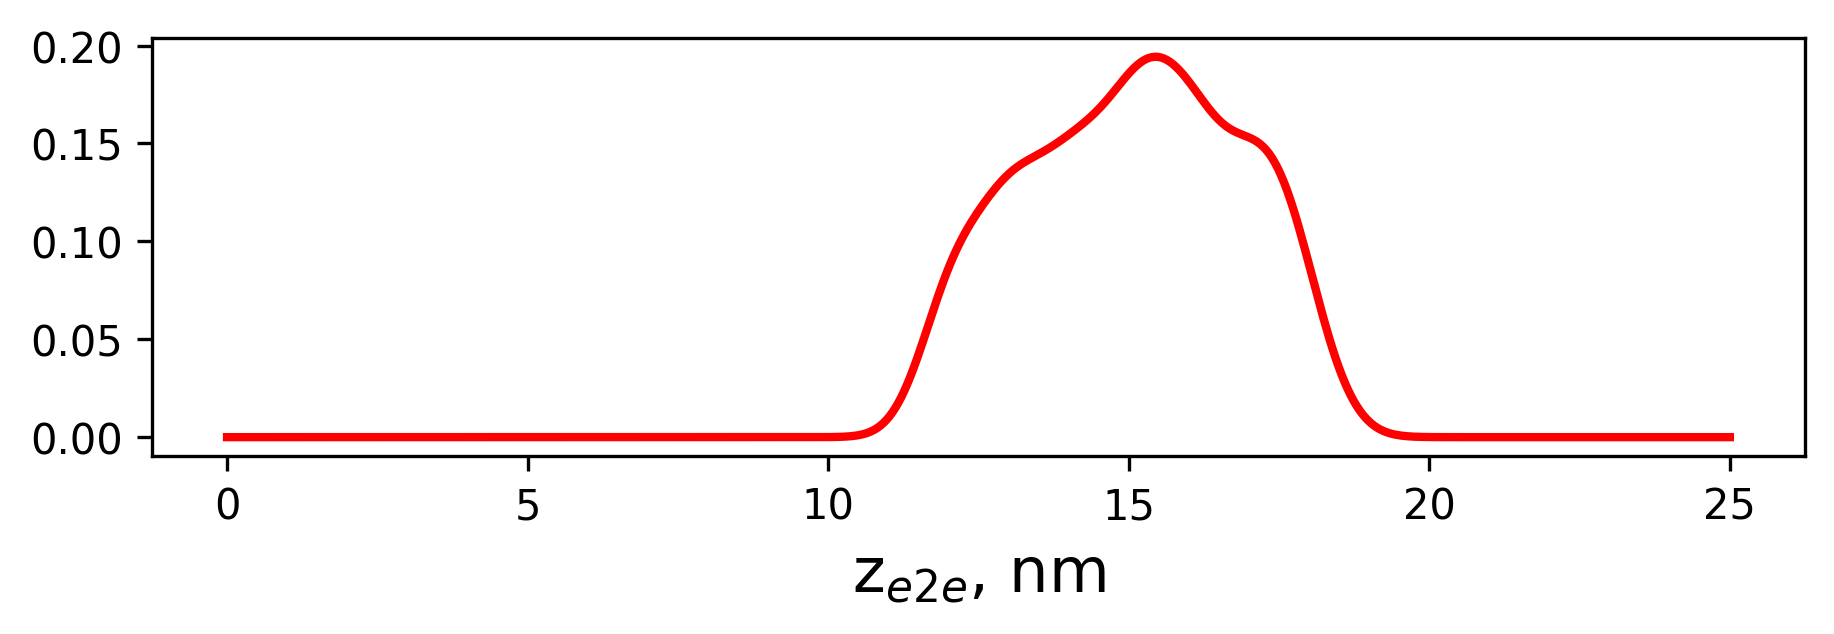

In [49]:
#@title KDE density estimation for the target receptor

#@markdown For category 1 receptor and category 2 (if rigid type), please provide the offset value due to the end-to-end distance of the ordered domain.

target_offset_value = 11.7 #@param {type:"raw"}

#@markdown Please choose the target type.

target_type ='dynamic' #@param ['dynamic','rigid']

if target_category == 2:
   if target_type == 'dynamic':
      target_offset_value = 0

from carboost.synapse.synapse_utils import get_KDE

xx=np.linspace(0,25,num=500)
x_vals=np.reshape(xx,(xx.shape[0],1))

dist = np.array(cos_dist_vals) + target_offset_value
dist = np.reshape(dist,(dist.shape[0],1))
prb = get_KDE(yval=dist,xval=x_vals,bandwidth=0.5)

probab_target = prb
max_target = max(dist)
xvals_target = x_vals
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(6,2),dpi=300,constrained_layout=True)
ax.plot(xx,prb,linewidth=2,c='r')
ax.set_xlabel("z$_{e2e}$, nm",fontsize=15)

## 2. CAR receptors

We will be loading the pre calculated KDEs from af2rave generated distribution used in the manuscript and $z_{e2e}$ distances from reduced MSA AF2.

In [50]:
hinge_sequence_lengths = [3,8,15,27,33,41,47,51,56,61]

In [51]:
from carboost.utils.load_utils import load_rMSA_AF2_KDEs
from carboost.utils.plot_utils import make_ridge_plots

#@markdown offset values from the scFv domain of the CAR receptor
car_offset_value = 0.0 #@param{type:"raw"} #nm

probab_cars, max_cars = load_rMSA_AF2_KDEs(hinge_sequence_lengths=hinge_sequence_lengths,bandwidth=0.5)

100%|██████████| 10/10 [00:00<00:00, 32.03it/s]

Please note that these distribution were calculated from reduce MSA approach on AlphaFold2.
These KDEs are not thermodynamically weighted 
Kindly, use this data for an estimate.
For hinge sequence length less than 40 amino acids, rMSA AF2 with chemical bias can give a reasonable estimate.


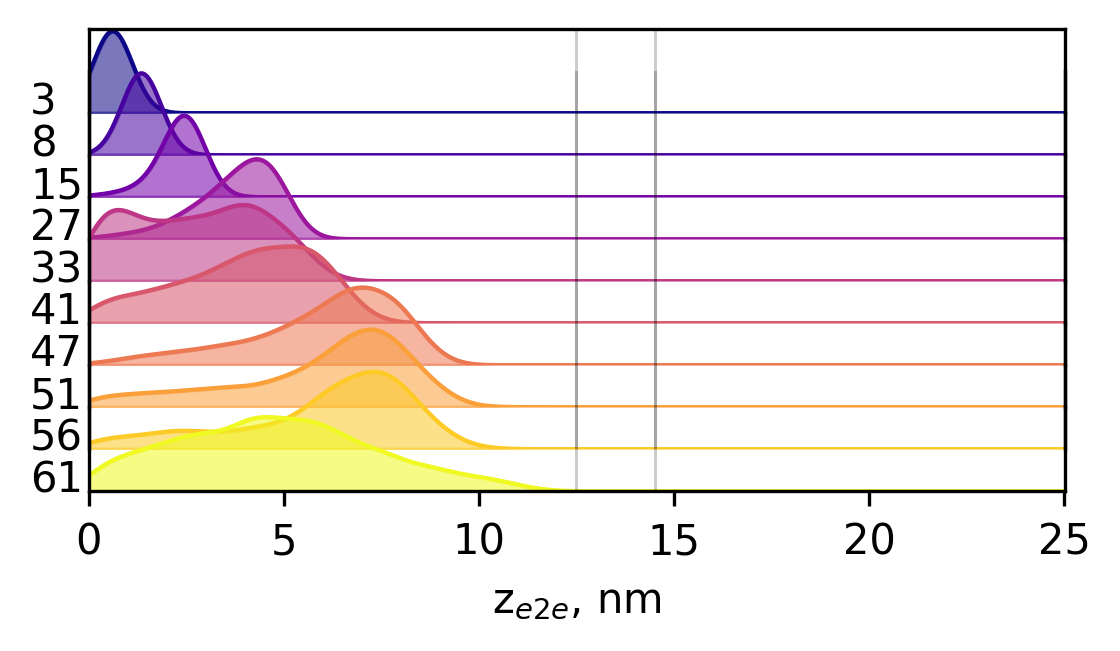

In [52]:
fig, axes = make_ridge_plots(
    probab_cars=probab_cars,
    figsize=(4.2,2),
    hspace=-0.5,
    fontsize=10,
    dpi=300,
    text_offset=0.06,
    show_plot=False,
    cmap='plasma'
)
for ax in axes:
    ax.plot([12.5,12.5],ax.get_ylim(),'k',linewidth=0.7,alpha=0.2)
    ax.plot([14.5,14.5],ax.get_ylim(),'k',linewidth=0.7,alpha=0.2)

In [53]:
#@title 3. Predicting `Phi` values
from carboost.synapse.synapse import run_carboost_pipeline, SynapseBase

Phi_values = {}
for hh_idx, hinge_len in enumerate(hinge_sequence_lengths):
    syn = SynapseBase(car_name=f"8H{hinge_len}",
                      hinge_length=f"{hinge_len}",
                      target_type=target_type,
                      target_kde=probab_target,
                      car_kdes=probab_cars[hinge_len]['kdes'],
                      method_name='rMSA_AF2',
                      x_car=probab_cars[hinge_len]['xval'].reshape(-1),
                      x_target=xx,
                      max_val_car=max_cars[hinge_len],
                      max_val_target=max(cos_dist_vals),
                      offset_value=car_offset_value+target_offset_value)
    Phi_values[hinge_len]={}
    Phi_values[hinge_len]['phi']=run_carboost_pipeline(syn)['phi']
    Phi_values[hinge_len]['phi_err']=run_carboost_pipeline(syn)['phi_err']

<>:7: SyntaxWarning: invalid escape sequence '\p'
<>:7: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-250910724.py:7: SyntaxWarning: invalid escape sequence '\p'
  ax.set_ylabel("$\phi$ values",fontsize=12)


Text(0, 0.5, '$\\phi$ values')

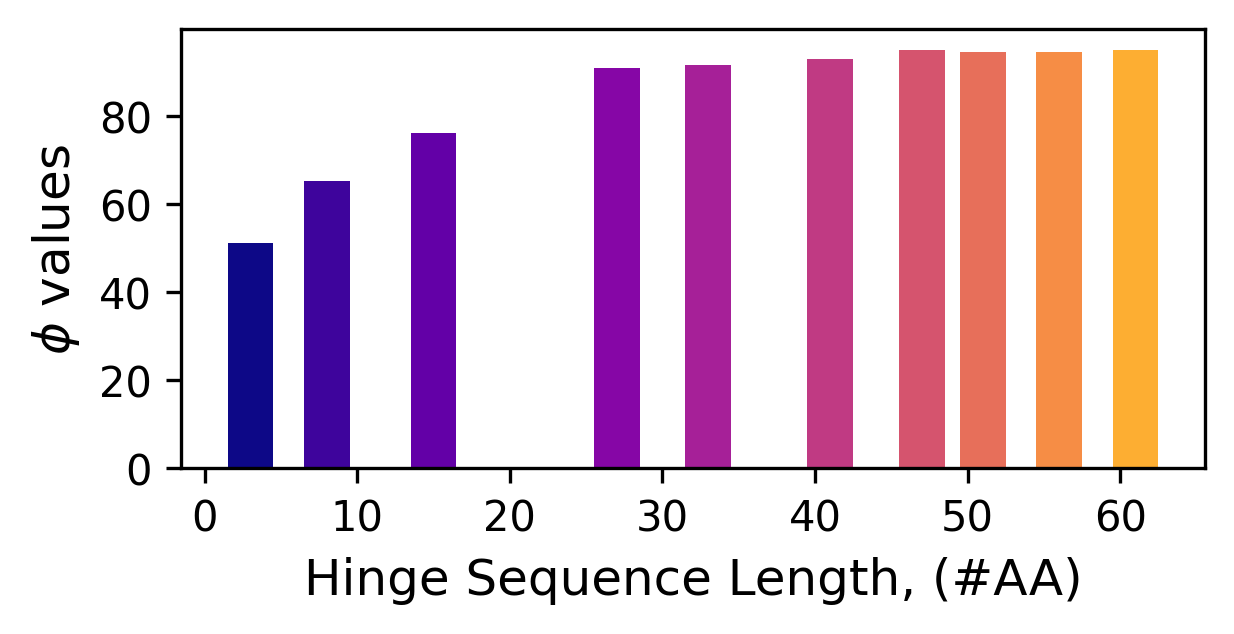

In [54]:
fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(4,2),dpi=300,constrained_layout=True)
colors = plt.cm.plasma(np.linspace(0, 1, len(hinge_sequence_lengths)+2))
for hh_idx, hinge_len in enumerate(hinge_sequence_lengths):
    ax.errorbar(hinge_len,Phi_values[hinge_len]['phi'],yerr=Phi_values[hinge_len]['phi_err'],c='k',linewidth=1,alpha=0.8)
    ax.bar(hinge_len,Phi_values[hinge_len]['phi'],color=colors[hh_idx],width=3)
ax.set_xlabel("Hinge Sequence Length, (#AA)",fontsize=12)
ax.set_ylabel("$\phi$ values",fontsize=12)